# Maine Rank Choice Voting (RCV) Analysis 

* Following the law here: https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html
* And rules here: https://www.maine.gov/sos/cec/elec/upcoming/pdf/250c535-2018-230-complete.pdf
* Data source: https://www.maine.gov/sos/cec/elec/results/results18.html#Nov6

In [1]:
import pandas as pd

ballot_df = pd.read_csv('data/ME_all.csv')
n_ballots = ballot_df.shape[0]
print("n_ballots:", n_ballots)
ballot_df.head()

n_ballots: 296077


,record,precinct,ballot_style,rank1,rank2,rank3,rank4,rank5
0,1,Fayette,CAN Ballot Style 130,"REP Poliquin, Bruce (5931)","REP Poliquin, Bruce","REP Poliquin, Bruce",undervote,undervote
1,2,Fayette,CAN Ballot Style 130,"REP Poliquin, Bruce (5931)",undervote,undervote,undervote,undervote
2,3,Fayette,CAN Ballot Style 130,"DEM Golden, Jared F. (5471)","Bond, Tiffany L.",undervote,undervote,undervote
3,4,Fayette,CAN Ballot Style 130,"REP Poliquin, Bruce (5931)","DEM Golden, Jared F.","Bond, Tiffany L.","DEM Golden, Jared F.","Hoar, William R.S."
4,6,Fayette,CAN Ballot Style 130,"REP Poliquin, Bruce (5931)",undervote,undervote,undervote,undervote


In [2]:
ballot_df['rank1'].value_counts()

REP Poliquin, Bruce (5931)     133793
DEM Golden, Jared F. (5471)    131003
Bond, Tiffany L.                16415
Hoar, William R.S.               6782
undervote                        6641
DEM Golden, Jared F.              819
overvote                          424
REP Poliquin, Bruce               200
Name: rank1, dtype: int64

## Data Cleaning

In [3]:
# remove ' (5931)'' from 'REP Poliquin, Bruce (5931)' and ' (5471)' from DEM Golden, Jared F. (5471)
# now each candidate has exaclty one string representing a vote for them.
ballot_df['rank1'] = ballot_df['rank1'].map(lambda choice: choice.split(' (')[0].strip())
ballot_df.rank1.value_counts()

REP Poliquin, Bruce     133993
DEM Golden, Jared F.    131822
Bond, Tiffany L.         16415
Hoar, William R.S.        6782
undervote                 6641
overvote                   424
Name: rank1, dtype: int64

In [4]:
# apply the same cleaning to all other ranks
for index in range(2, 6):
    rank = 'rank{}'.format(index)
    print("Cleaning", rank)
    ballot_df[rank] = ballot_df[rank].map(lambda choice: choice.split(' (')[0].strip())

Cleaning rank2
Cleaning rank3
Cleaning rank4
Cleaning rank5


In [5]:
# ensure strings are consistent across all columns
unique_candidate_set = set()
for index in range(1, 6):
    rank = 'rank{}'.format(index)
    rank_i_unique_candidate_set = set(ballot_df[rank].unique())
    # take the union of unique candidates so far and unique candidates in this round
    unique_candidate_set = unique_candidate_set | rank_i_unique_candidate_set 
unique_candidate_set

{'Bond, Tiffany L.',
 'DEM Golden, Jared F.',
 'Hoar, William R.S.',
 'REP Poliquin, Bruce',
 'overvote',
 'undervote'}

We now see that across all ranks, each candidate is represented by exaclty one unique string.

## Definitions
From [Tile 21-A, §723-A](https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html):

>A. "Batch elimination" means the simultaneous defeat of multiple candidates for whom it is mathematically impossible to be elected.   [IB 2015, c. 3, §5 (NEW).]

>B. "Continuing ballot" means a ballot that is not an exhausted ballot.   [IB 2015, c. 3, §5 (NEW).]

>C. "Continuing candidate" means a candidate who has not been defeated.   [IB 2015, c. 3, §5 (NEW).]

In [6]:
candidate_set = {
    'Bond, Tiffany L.',
    'DEM Golden, Jared F.',
    'Hoar, William R.S.',
    'REP Poliquin, Bruce'
}
continuing_candidate_set = {
    'Bond, Tiffany L.',
    'DEM Golden, Jared F.',
    'Hoar, William R.S.',
    'REP Poliquin, Bruce'
}

>D. "Exhausted ballot" means a ballot that does not rank any continuing candidate, contains an overvote at the highest continuing ranking or contains 2 or more sequential skipped rankings before its highest continuing ranking. 

In [7]:
# Constants
OVERVOTE = 'overvote'
UNDERVOTE = 'undervote'

# Helper functions
def ballot_has_two_consecutive_skipped_rankings(ballot):
    highest_continuing_rank = ballot['highest_continuing_rank']
    if highest_continuing_rank < 3:
        return False
    else:
        rank_one_before = "rank{}".format(highest_continuing_rank - 1)
        rank_two_before = "rank{}".format(highest_continuing_rank - 2)
    return (ballot[rank_one_before] == UNDERVOTE) and (ballot[rank_two_before] == UNDERVOTE)

def ballot_exhausted_for_overvote(ballot):
    highest_continuing_rank = ballot['highest_continuing_rank']
    if highest_continuing_rank in {1,2,3,4,5}:
        return ballot["rank{}".format(highest_continuing_rank)] == OVERVOTE
    else:
        return False

def mark_exhausted_ballots(continuing_ballot_df, continuing_candidate_set):
    # determine which ballot rank a continuing candidate according to https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html
    ranks_a_continuing_candidate = (continuing_ballot_df['rank1'].isin(continuing_candidate_set)
        | continuing_ballot_df['rank2'].isin(continuing_candidate_set)
        | continuing_ballot_df['rank3'].isin(continuing_candidate_set)
        | continuing_ballot_df['rank4'].isin(continuing_candidate_set)
        | continuing_ballot_df['rank5'].isin(continuing_candidate_set))
    continuing_ballot_df['does_not_rank_any_continuing_candidate'] = ~ranks_a_continuing_candidate
    n_exhausted_no_rank = continuing_ballot_df['does_not_rank_any_continuing_candidate'].value_counts()[True]
    print(n_exhausted_no_rank, "ballots exhausted for not ranking any continuing candidate. ({:.2%} of total ballots)".format(n_exhausted_no_rank/n_ballots))
    
    # determine the highest continuing rank according to https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html
    # E. "Highest continuing ranking" means the highest ranking on a voter's ballot for a continuing candidate.   [IB 2015, c. 3, §5 (NEW).]
    continuing_ballot_df['highest_continuing_rank'] = 6 # defaults to 6 so that if the ballot is all undervotes, then ballot_has_two_consecutive_skipped_rankings will catch it
    for rank_idx in range(5, 0, -1):
        continuing_ballot_df['rank_choice_in_continuing_candidate_set'] = continuing_ballot_df["rank{}".format(rank_idx)].isin(continuing_candidate_set | {OVERVOTE})
        continuing_ballot_df.loc[continuing_ballot_df['rank_choice_in_continuing_candidate_set'], 'highest_continuing_rank'] = rank_idx
    
    # determine which ballots have an overvote at their highest continuing ranking according to https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html
    # H. "Overvote" means a circumstance in which a voter has ranked more than one candidate at the same ranking.   [IB 2015, c. 3, §5 (NEW).]
    continuing_ballot_df['overvote'] = continuing_ballot_df.apply(lambda ballot: ballot_exhausted_for_overvote(ballot), axis=1)
    n_exhausted_overvote = continuing_ballot_df['overvote'].value_counts()[True]
    print(n_exhausted_overvote, "ballots exhausted for overvotes. ({:.2%} of total ballots)".format(n_exhausted_overvote/n_ballots))
     
    continuing_ballot_df['two_consecutive_skipped_rankings'] = continuing_ballot_df.apply(lambda ballot: ballot_has_two_consecutive_skipped_rankings(ballot), axis=1)
    n_exhausted_skipped = continuing_ballot_df['two_consecutive_skipped_rankings'].value_counts()[True]    
    print(n_exhausted_skipped, "ballots exhausted for two consecutive skipped rankings. ({:.2%} of total ballots)".format(n_exhausted_skipped/n_ballots))
    
    continuing_ballot_df['exhausted'] = continuing_ballot_df['overvote'] | continuing_ballot_df['two_consecutive_skipped_rankings'] | continuing_ballot_df['does_not_rank_any_continuing_candidate']
    n_exhausted = continuing_ballot_df['exhausted'].value_counts()[True]
    print(n_exhausted, "total ballots exhausted.({:.2%} of total ballots)".format(n_exhausted/n_ballots))
    return continuing_ballot_df

## Procedure
Note: in its current form this script follows the "procedure" section of the [statute](https://legislature.maine.gov/statutes/21-A/title21-Asec723-A.html). Therefore it does not implement batch elimination, which seems to have been in 2018 used based on the Maine SOS [summary report](https://www.maine.gov/sos/cec/elec/results/2018/updated-summary-report-CD2.xls) having only two rounds. This doesn't effect the outcome, but if one wanted to make arguements based on number of ballots exhausted per round it would make sense to implement batch elimination.

>Except as provided in subsections 3 and 4, the following procedures are used to determine the winner of an election determined by ranked-choice voting. The ranked‑choice voting count must proceed in rounds. In each round, the number of votes for each continuing candidate must be counted. Each continuing ballot counts as one vote for its highest-ranked continuing candidate for that round. Exhausted ballots are not counted for any continuing candidate. The round then ends with one of the following 2 potential outcomes.

>A. If there are 2 or fewer continuing candidates, the candidate with the most votes is declared the winner of the election.   [IB 2015, c. 3, §5 (NEW).]

>B. If there are more than 2 continuing candidates, the last-place candidate is defeated and a new round begins.   [IB 2015, c. 3, §5 (NEW).]

In [8]:
decided = False
round_index = 1
votes_by_round_df = pd.DataFrame()
continuing_ballot_df = ballot_df
round_to_ballot_df = {}

def get_highest_ranked_candidate(ballot):
    rank_idx = ballot['highest_continuing_rank']
    if rank_idx in {1,2,3,4,5}:
        return ballot["rank{}".format(rank_idx)]
    else:
        return False

while not decided:
    print("\nStarting Round", round_index)

    # determine which ballots are exhausted
    print("Determining which ballots are exhausted")
    continuing_ballot_df_exhausted_marked = mark_exhausted_ballots(continuing_ballot_df, continuing_candidate_set)
    
    # determine the highest ranked continuing candidate for each ballot
    continuing_ballot_df['highest_ranked_continuing_candidate'] = continuing_ballot_df.apply(lambda ballot: get_highest_ranked_candidate(ballot), axis=1)  
    # record this round's ballot dataframe for analysis
    round_to_ballot_df[round_index] = continuing_ballot_df_exhausted_marked
    
    # remove exhausted ballots from consideration
    continuing_ballot_df = pd.DataFrame(continuing_ballot_df_exhausted_marked[~continuing_ballot_df_exhausted_marked['exhausted']])
    assert set(continuing_ballot_df['highest_ranked_continuing_candidate'].unique()) <= continuing_candidate_set
                                                                              
    # for each continuing ballot, assign one vote for its highest ranked continuing candidate                              
    votes_by_round_df[round_index] = continuing_ballot_df['highest_ranked_continuing_candidate'].value_counts()

    if len(continuing_candidate_set) <= 2:
        decided = True
        winning_candidate = votes_by_round_df[votes_by_round_df[round_index]==votes_by_round_df[round_index].max()].index[0]
        print(winning_candidate, "won!")
    else:
        # Eliminate the continuing candidate with the fewest
        eliminated_candidate = votes_by_round_df[votes_by_round_df[round_index]==votes_by_round_df[round_index].min()].index[0]
        continuing_candidate_set.remove(eliminated_candidate)
        print(eliminated_candidate, "was eliminated.")
    round_index += 1
                                                                              
votes_by_round_df


Starting Round 1
Determining which ballots are exhausted
5928 ballots exhausted for not ranking any continuing candidate. (2.00% of total ballots)
462 ballots exhausted for overvotes. (0.16% of total ballots)
6018 ballots exhausted for two consecutive skipped rankings. (2.03% of total ballots)
6453 total ballots exhausted.(2.18% of total ballots)
Hoar, William R.S. was eliminated.

Starting Round 2
Determining which ballots are exhausted
2130 ballots exhausted for not ranking any continuing candidate. (0.72% of total ballots)
27 ballots exhausted for overvotes. (0.01% of total ballots)
2044 ballots exhausted for two consecutive skipped rankings. (0.69% of total ballots)
2162 total ballots exhausted.(0.73% of total ballots)
Bond, Tiffany L. was eliminated.

Starting Round 3
Determining which ballots are exhausted
5991 ballots exhausted for not ranking any continuing candidate. (2.02% of total ballots)
123 ballots exhausted for overvotes. (0.04% of total ballots)
5728 ballots exhausted 

,1,2,3
"REP Poliquin, Bruce",134184,135073.0,138932.0
"DEM Golden, Jared F.",132013,133216.0,142442.0
"Bond, Tiffany L.",16552,19173.0,NaN
"Hoar, William R.S.",6875,NaN,NaN


## Data Analysis
1) What percentage of voters expressed first-choice support for each of the four candidates?

In [9]:
r1 = round_to_ballot_df[1]
df = pd.DataFrame()
df['n_votes_rank1'] = r1['rank1'].value_counts()
df['dec_votes_rank1'] = df['n_votes_rank1'] /n_ballots
df['pct_votes_rank1'] = df['dec_votes_rank1'].map('{:.2%}'.format)

df['n_votes_first_choice'] = r1['highest_ranked_continuing_candidate'].value_counts()
df['dec_votes_first_choice'] = df['n_votes_first_choice'] /n_ballots
df['pct_votes_first_choice'] = df['dec_votes_first_choice'].map('{:.2%}'.format)

df['dec_delta'] = df['dec_votes_first_choice'] - df['dec_votes_rank1']
df['pct_delta'] = df['dec_delta'].map('{:.2%}'.format)

df[['pct_votes_first_choice', 'pct_votes_rank1', 'pct_delta']]

,pct_votes_first_choice,pct_votes_rank1,pct_delta
"REP Poliquin, Bruce",45.36%,45.26%,0.11%
"DEM Golden, Jared F.",44.61%,44.52%,0.09%
"Bond, Tiffany L.",5.60%,5.54%,0.06%
"Hoar, William R.S.",2.34%,2.29%,0.05%
undervote,nan%,2.24%,nan%
overvote,0.16%,0.14%,0.01%


2) What percentage of voters expressed support at any ranking for each of the four candidates?

In [10]:
# without removing duplicates
r1 = round_to_ballot_df[1]
df2 = pd.DataFrame()
df2['n_votes_rank1'] = r1['rank1'].value_counts()
df2['n_votes_rank2'] = r1['rank2'].value_counts()
df2['n_votes_rank3'] = r1['rank3'].value_counts()
df2['n_votes_rank4'] = r1['rank4'].value_counts()
df2['n_votes_rank5'] = r1['rank5'].value_counts()
df2['n_votes_total'] = df2.sum(axis=1)
df2['dec_votes'] = df2['n_votes_total'] /n_ballots
df2['pct_votes'] = df2['dec_votes'].map('{:.2%}'.format)
print("Percentage of voters expressing support at any ranking (with duplicates)")
df2[['pct_votes', 'n_votes_total']]

Percentage of voters expressing support at any ranking (with duplicates)


,pct_votes,n_votes_total
"REP Poliquin, Bruce",72.23%,213847
"DEM Golden, Jared F.",64.72%,191618
"Bond, Tiffany L.",45.05%,133377
"Hoar, William R.S.",40.81%,120816
undervote,276.50%,818651
overvote,0.70%,2076


In [11]:
# removing duplicates
candidate_to_votes = {}
for candidate in unique_candidate_set:
    candidate_to_votes[candidate] = ballot_df.apply(lambda ballot: candidate in set(ballot), axis=1).sum()
df2['n_votes_total_no_dups'] = df2.index.map(candidate_to_votes)
df2['dec_votes_no_dups'] = df2['n_votes_total_no_dups'] /n_ballots
df2['pct_votes_no_dups'] = df2['dec_votes_no_dups'].map('{:.2%}'.format)
print("Percentage of voters expressing support at any ranking (no duplicates)")
df2[['pct_votes_no_dups', 'n_votes_total_no_dups']]

Percentage of voters expressing support at any ranking (no duplicates)


,pct_votes_no_dups,n_votes_total_no_dups
"REP Poliquin, Bruce",64.05%,189627
"DEM Golden, Jared F.",60.95%,180457
"Bond, Tiffany L.",44.45%,131602
"Hoar, William R.S.",40.45%,119754
undervote,96.83%,286682
overvote,0.67%,1994


In [12]:
df2['dec_delta'] = df2['dec_votes'] - df2['dec_votes_no_dups']
df2['pct_delta'] = df2['dec_delta'].map('{:.2%}'.format)
print("Percentage of voters expressing support at any ranking (compare duplicates vs. no duplicates)")
df2[['pct_votes','pct_votes_no_dups', 'pct_delta']]

Percentage of voters expressing support at any ranking (compare duplicates vs. no duplicates)


,pct_votes,pct_votes_no_dups,pct_delta
"REP Poliquin, Bruce",72.23%,64.05%,8.18%
"DEM Golden, Jared F.",64.72%,60.95%,3.77%
"Bond, Tiffany L.",45.05%,44.45%,0.60%
"Hoar, William R.S.",40.81%,40.45%,0.36%
undervote,276.50%,96.83%,179.67%
overvote,0.70%,0.67%,0.03%


3) Calculate histograms of how many choices were made by voters, stratified by their first choice. This will test if Golden and Poliquin first-choice voters tended to truncate their ballots, or if Hoar and Bond first-choice voters tended to exercise their lower-rank option more. 

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [14]:
def get_n_unique_choices(ballot):
    choices = {ballot["rank{}".format(rank_idx)] for rank_idx in range(1,6)}
    candidate_choices = choices & candidate_set
    return len(candidate_choices)

r1 = round_to_ballot_df[1]
r1['n_choices'] = r1.apply(get_n_unique_choices,axis=1)

In [15]:
r1 = round_to_ballot_df[1]
df = r1
df = df.rename(columns={'highest_ranked_continuing_candidate':'First Choice Candidate', 'n_choices':"Number of choices expressed on ballot"})
ct = pd.crosstab(df["Number of choices expressed on ballot"], df['First Choice Candidate'])
ct = ct[ct.index.isin([1,2,3,4])][list(candidate_set)]
ct['Golden/Jared'] = ct['DEM Golden, Jared F.'] + ct['REP Poliquin, Bruce']
ct['Bond/Hoar'] = ct['Bond, Tiffany L.'] + ct['Hoar, William R.S.']
dec_ct = ct / ct.sum()
ct

First Choice Candidate,"Bond, Tiffany L.","REP Poliquin, Bruce","DEM Golden, Jared F.","Hoar, William R.S.",Golden/Jared,Bond/Hoar
Number of choices expressed on ballot,,,,,,
1,4379,89650,51643,2159,141293,6538
2,2748,8895,17296,1056,26191,3804
3,2296,6588,25396,890,31984,3186
4,7158,29182,37756,2812,66938,9970


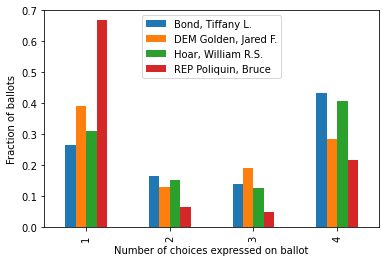

In [16]:
dec_ct[['Bond, Tiffany L.',
 'DEM Golden, Jared F.',
 'Hoar, William R.S.',
 'REP Poliquin, Bruce']].plot.bar().legend(loc=9)
plt.ylabel('Fraction of ballots')
plt.show()

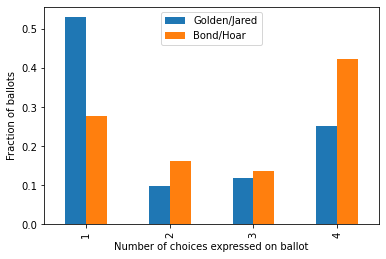

In [17]:
dec_ct[['Golden/Jared', 'Bond/Hoar']].plot.bar().legend(loc=9)
plt.ylabel('Fraction of ballots')
plt.show()

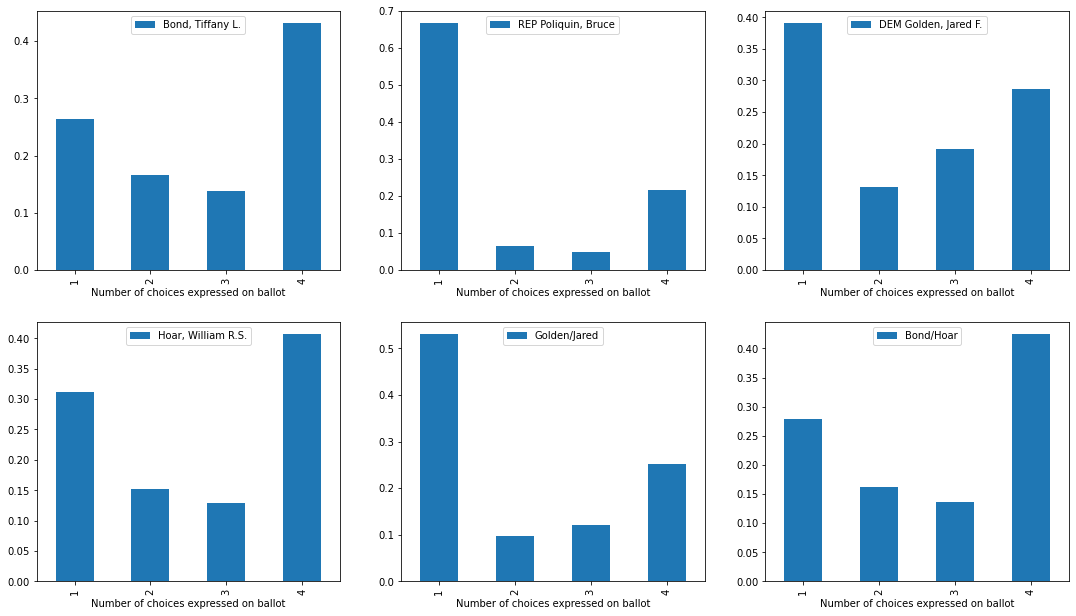

In [18]:
fig, axs = plt.subplots(2,3)
axs = axs.flatten()
for idx, col in enumerate(dec_ct.columns):
    dec_ct[col].plot.bar(ax=axs[idx]).legend(loc=9)
fig.set_size_inches(18.5, 10.5)

#### Sam style cumulative histograms for Kolmogorov–Smirnov significance testing

In [19]:
# Helper Functions
def ax_superimpose(ax, dataset, alpha=.05):
    for title, data in dataset:
        x = data.sort_values()
        l = len(data)
        y = [x/l for x in range(l)]
        p = ax.plot(x, y, label=title)
        color = p[0].get_color()
        mean_voteshare = np.mean(x)
        ax.legend(prop={'size': 10}, loc=4)
        ax.text((mean_voteshare -.0075), -.2, 'AVG.', fontsize=14, color=color)
        ax.axvline(x=mean_voteshare, color=color)
    D_max, p_value = stats.ks_2samp(dataset[0][1],dataset[1][1])
    significant = p_value < alpha 
    ax.text(3.3, .13, 'KS P={0:.5f}'.format(p_value), fontsize=14, color='red' if significant else 'black')

def compare(data, pairs=[(0,1),(0,2),(1,3),(2,3)]):
    fig, axs = plt.subplots(2,2)
    axs = axs.flatten()
    for idx, pair in enumerate(pairs):
        dataset = [data[pair[0]],data[pair[1]]]
        ax_superimpose(axs[idx], dataset)
    fig.set_size_inches(18.5, 10.5)
    
def hist(ax, data, alpha=.05):
    title, data = data
    x = data.sort_values()
    l = len(data)
    y = [x/l for x in range(l)]
    p = ax.plot(x, y, label=title)
    color = p[0].get_color()
    mean_voteshare = np.mean(x)
    ax.legend(prop={'size': 10}, loc=4)
    ax.text((mean_voteshare -.0075), -.2, 'AVG.', fontsize=14, color=color)
    ax.axvline(x=mean_voteshare, color=color)

def solo4(data):
    fig, axs = plt.subplots(2,2)
    axs = axs.flatten()
    for idx in range(4):
        hist(axs[idx], data[idx])
    fig.set_size_inches(18.5, 10.5)

def solo2(data):
    fig, axs = plt.subplots(1,2)
    axs = axs.flatten()
    for idx in range(2):
        hist(axs[idx], data[idx])
    fig.set_size_inches(18.5, 5.5)

In [20]:

df = r1
data4 = [
    ('DEM Golden, Jared F.', df[df['highest_ranked_continuing_candidate'] == 'DEM Golden, Jared F.']['n_choices']),
    ('REP Poliquin, Bruce', df[df['highest_ranked_continuing_candidate'] == 'REP Poliquin, Bruce']['n_choices']),
    ('Bond, Tiffany L.', df[df['highest_ranked_continuing_candidate'] == 'Bond, Tiffany L.']['n_choices']),
    ('Hoar, William R.S.', df[df['highest_ranked_continuing_candidate'] == 'DEM Golden, Jared F.']['n_choices'])
]

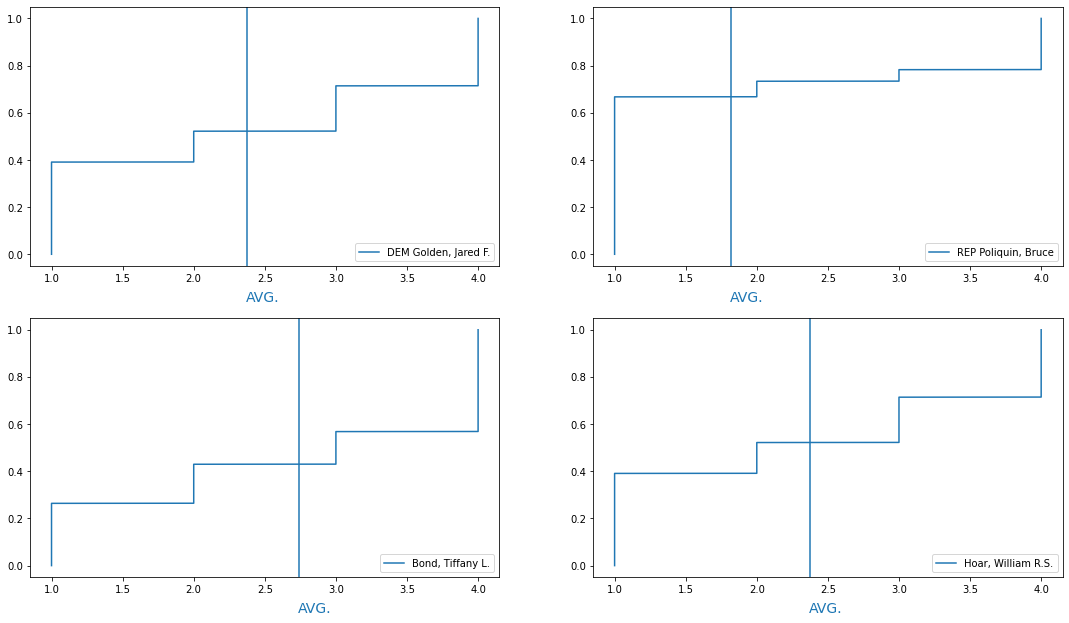

In [21]:
solo4(data4)

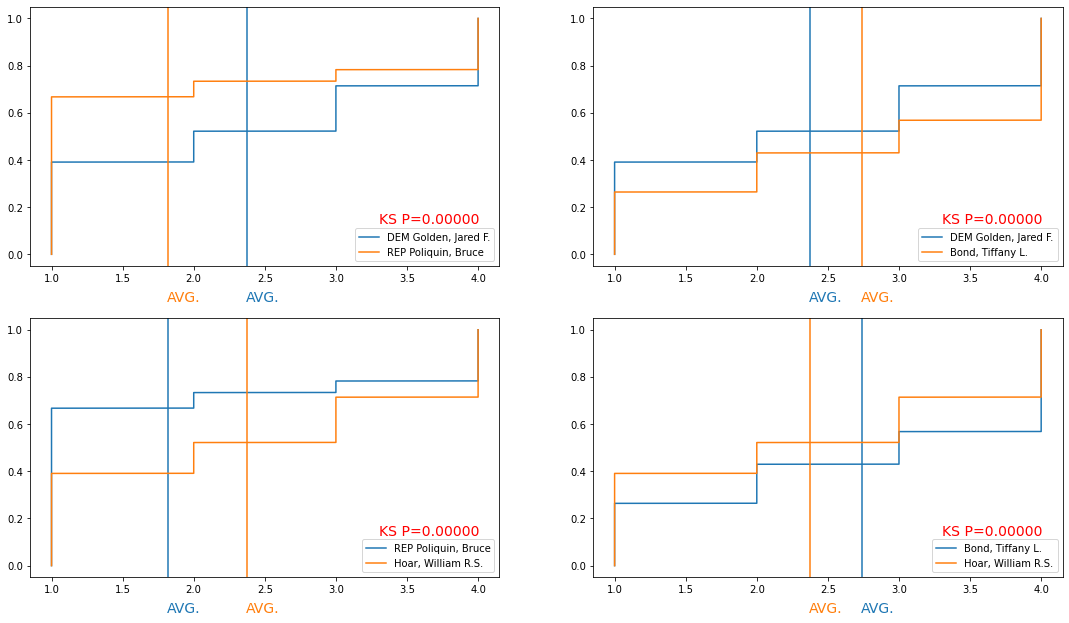

In [22]:
compare(data4)

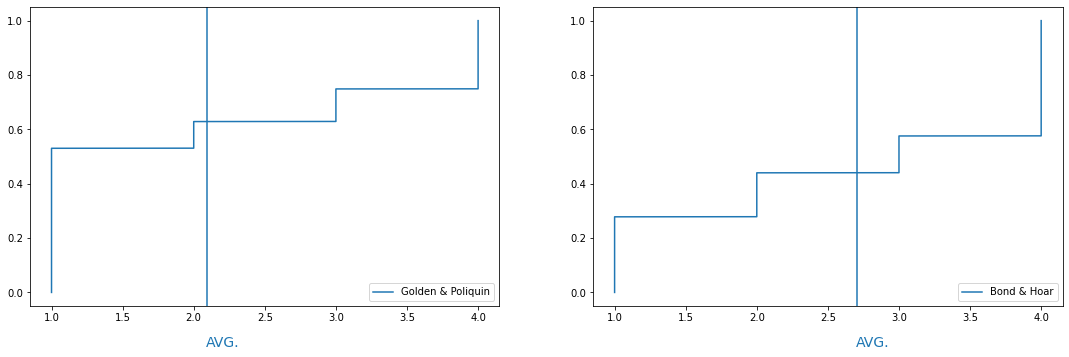

In [23]:
data2 = [
    ('Golden & Poliquin', df[df['highest_ranked_continuing_candidate'].isin({'DEM Golden, Jared F.','REP Poliquin, Bruce'})]['n_choices']),
    ('Bond & Hoar', df[df['highest_ranked_continuing_candidate'].isin({'Bond, Tiffany L.','Hoar, William R.S.'})]['n_choices']),
]
solo2(data2)

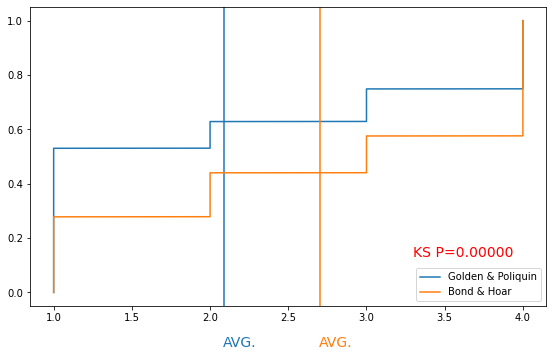

In [24]:
fig, ax = plt.subplots(1,1)
ax_superimpose(ax, data2)
fig.set_size_inches(9.25, 5.5)